Radial grid information:

dx =  0.01
x_min =  -8.0
n_points =  1260
r(0) =  0.00033546262790251185
r(n_points) =  99.48431564193378
-----------------------------------------------

potential saved in 'potential.csv'

-----------------------------------------------

convergence achived at iter #   15, de =  -2.53426507e-13, e =  -2.77402883e-02
-----------------------------------------------



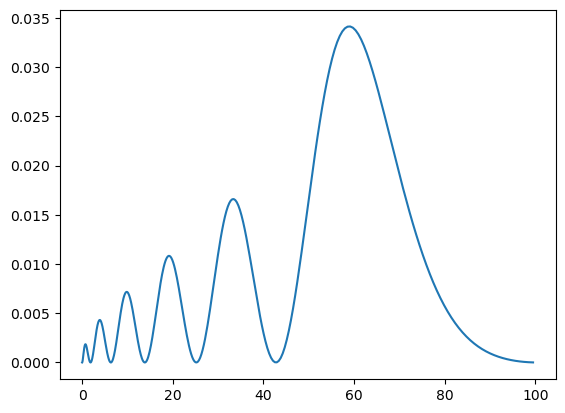

In [14]:
#Radial Schrodinger equation using Numerov method - atomic (Ry) units

import numpy as np
import matplotlib.pyplot as plt
import sys
import pandas as pd


#functions
def prepare_grid(n_points, x_min, dx):

    #preparing x-array
    x = np.linspace(x_min, x_min + ((n_points - 1) * dx), n_points)
    x = np.append(x, x[n_points - 1] + dx)

    #generate r, sqrt_r, and r^2 based on logarithmic x grid
    r = np.exp(x)
    sqrt_r = np.sqrt(r)
    r2 = np.power(r, 2)

    #print grid information
    print("Radial grid information:\n")
    print("dx = ", dx)
    print("x_min = ", x_min)
    print("n_points = ", n_points)
    print("r(0) = ", r[0])
    print("r(n_points) = ", r[n_points])
    print("-----------------------------------------------\n")

    return r, sqrt_r, r2


def potential(r):

    #definition of the potential
    v_pot = -2/r

    #saving the potential to CSV
    df_pot = pd.DataFrame({"r": r, "V(r)": v_pot})
    df_pot.to_csv("potential.csv", index=False)
    print("potential saved in 'potential.csv'\n")
    return v_pot
   
       
def solve_schrodinger(n_points, dx, v_pot, r2, r, sqrt_r, n, l):
    #solve the schrodinger equation in radial coordinates on a logarithmic
    #grid by Numerov method - atomic units

    eps = 1E-10 #tolerance for eigenvalue
    n_iter = 200
    
    ddx12 = (dx * dx) / 12

    sqlhf = (l + 0.5) * (l + 0.5) #
    x2l2 = 2 * l +2
    #initial lower and upper bounds to the eigenvalue
    #actually here we should write something that compute the minimum
    print("-----------------------------------------------\n")
    e_upp = v_pot[n_points]
    e_low = e_upp

    for j in range(0, n_points + 1):
            e_low = np.minimum(e_low, sqlhf / r2[j] + v_pot[j])

    if (e_upp - e_low < eps):
        print("error in solving schrodinger: e_upp and e_low coincide", file = sys.stderr)
        sys.exit(1)
            
    e = (e_low + e_upp) * 0.5

    f = np.zeros(n_points + 1) #f-function for Numerov

    class_inv = -1 #index of classical inversion point

    #start loop on energy
    de = 1E10 #any number greater than eps
    i = 0
    
    while i  < n_iter and np.absolute(de) > eps:
        #set up the f-function (in a way to determine the position of its last change
        #of sign)

        f[0] = ddx12 * ((r2[0] * (v_pot[0] - e)) + sqlhf)
        for j in range(1, n_points + 1):
            f[j] = ddx12 * ((r2[j] * (v_pot[j] - e)) + sqlhf)

            #if f[j] is exactly zero (unlikely) the change of sign is not observed 
            #trick to prevent missing change of sign
            if (f[j] == 0.):
                f[j] = 1E-20

            #take the index of classical inversion
            if np.sign(f[j]) != np.sign(f[j - 1]):
                class_inv = j

        if class_inv < 0 or class_inv >= n_points - 2:
            print(f"{class_inv:4d} {n_points:4d}")
            print("error in solving schrodinger: last change of sign too far", file = sys.stderr)
            sys.exit(1)

        #let's rewrite the f-function how required by numerov method
        
        f = 1 - f

        y = np.zeros(n_points + 1) #wavefunction

        #wavefunction in the first two points

        nodes = n - l - 1
        y[0] = (r[0] ** (l + 1)) * (1 - 2 * r[0] / x2l2) / sqrt_r[0]
        y[1] = (r[1] ** (l + 1)) * (1 - 2 * r[1] / x2l2) / sqrt_r[1]
        #outward integration with node counting
        n_cross = 0
        for j in range(1, class_inv):
            y[j + 1] = ((12. - f[j] * 10.) * y[j] - f[j - 1] * y[j - 1]) / f[j + 1]
            if np.sign(y[j]) != np.sign(y[j + 1]):
                n_cross += 1

        y_matching = y[class_inv] #value of the wavefunction at classical turning point
        
        #check the number of crossings
        if (n_cross != nodes):
            #incorrect number of nodes
            if (n_cross > nodes):
                e_upp = e
            else:
                e_low = e

            e = (e_upp + e_low) * 0.5

        else:
            #correct number of nodes, we can perform inward integration.

            #determination of the rave function in last two points
            y[n_points] = dx
            y[n_points - 1] = (12. - f[n_points] * 10.) * y[n_points] / f[n_points - 1]

            #inward integration
            for j in range(n_points - 1, class_inv, -1):
                y[j - 1] = ((12. - f[j] * 10.) * y[j] - f[j + 1] * y[j + 1]) / f[j - 1]
                if (y[j - 1] > 1E10):
                    for m in range(n_points, j - 2, -1):
                        y[m] /= y[j - 1]

            #rescale the function to match at the classical turning point
            y_matching /= y[class_inv]
            for j in range(class_inv, n_points + 1):
                y[j] *= y_matching

            #normalize on the segment
            norm = 0.

            for j in range(1, n_points + 1):
                norm += y[j] * y[j] * r2[j] * dx

            norm = np.sqrt(norm)

            for j in range(0, n_points + 1):
                y[j] /= norm

            #find the value of the cusp at the matchin point
            j = class_inv
            y_cusp = (y[j - 1] * f[j - 1] + f[j + 1] * y[j + 1] + f[j] * 10. * y[j]) / 12.
            df_cusp = f[j] * (y[j] / y_cusp - 1.)

            # eigenvalue update using perturbation theory
            de = df_cusp / ddx12 * y_cusp * y_cusp * dx
            if (de > 0.):
                e_low = e
            if (de < 0.):
                e_upp = e

            e = e + de
            #prevent e to go out of bounds ( e > e_upp or e < e_low)
            #could happen far from convergence
            e = np.minimum(e, e_upp)
            e = np.maximum(e, e_low)

        i += 1
    
    #convergence not achived
    if (np.abs(de) > eps):
        if n_cross != nodes:
            print(f"n_cross={n_cross:4d} nodes={nodes:4d} class_inv={class_inv:4d} " 
                f"e={e:16.8e} e_low={e_low:16.8e} e_upp={e_upp:18.8e}", file=sys.stderr)
        else:
            print(f"e={e:16.8e} de={de:16.8e}", file=sys.stderr)

        print(f"solve_schrodinger not converged after {n_iter} iterations", file=sys.stderr)
        sys.exit(1)

    #convergence achived
    print(f"convergence achived at iter # {i:4d}, de = {de:16.8e}, e = {e:16.8e}")

    return e, y

#program starts here-------------------------------------------------------------------------
#parameters
r_max = 100. 
x_min = -8. #corresponds to r_min == Bohr radii
dx = 0.01 #grid spacing

#number of points for our parameters
n_points = int((np.log(r_max) - x_min) / dx)

#initialize logarithmic grid
r, sqrt_r, r2 = prepare_grid(n_points, x_min, dx)

#initialize potential
v_pot = potential(r)

n = 6
l = 0

e_0, y_0 = solve_schrodinger(n_points, dx, v_pot, r2, r, sqrt_r, n, l)
#solve_schrodinger(n_points, dx, v_pot, r2, r, sqrt_r, manual_node)
print("-----------------------------------------------\n")

plt.plot(r, r * y_0 * y_0)
